# JAX vs. Nabla: Training a Transformer (CPU)

This notebook provides a detailed, from-scratch implementation of a Transformer model for a sequence-reversal task. The goal is to compare the APIs and programming models of two deep learning frameworks: **JAX** and **Nabla**.

Each core component of the Transformer is implemented for both frameworks in the same code cell, allowing for a direct comparison of their syntax and approach. The implementations are kept as architecturally similar as possible to highlight the differences in the libraries themselves.

**Learning Objectives:**
- Understand the fundamental building blocks of the Transformer architecture.
- Compare the functional, JIT-centric approaches of JAX and Nabla.
- See how a complete sequence-to-sequence model is built and trained in both frameworks.

At the end of the notebook, you will find two separate code cells that run the complete training loops, one for JAX and one for Nabla, followed by visualization of the training loss curves.

## 1. Imports and Configuration

First, we import the necessary libraries and define the configuration parameters for our model and training task. These parameters are identical for both the JAX and Nabla implementations to ensure a fair comparison.

In [3]:
# Installation
import sys

IN_COLAB = "google.colab" in sys.modules


def install_packages():
    import subprocess

    subprocess.run(
        [
            sys.executable,
            "-m",
            "pip",
            "install",
            "modular",
            "--extra-index-url",
            "https://download.pytorch.org/whl/cpu",
            "--index-url",
            "https://dl.modular.com/public/nightly/python/simple/",
        ],
        check=True,
    )
    subprocess.run(
        [
            sys.executable,
            "-m",
            "pip",
            "install",
            "nabla-ml",
            "jax",
            "jaxlib",
            "matplotlib",
            "numpy",
            "--upgrade",
        ],
        check=True,
    )


try:
    import time
    from typing import Any, List

    import jax
    import jax.numpy as jnp
    import matplotlib.pyplot as plt
    import numpy as np
    from jax import value_and_grad

    import nabla as nb

    print("✅ All packages imported successfully!")
except ImportError as e:
    print(f"❌ Import failed: {e}")
    print("🔄 Installing required packages...")
    install_packages()

    # Retry imports after installation
    import time
    from typing import Any

    import jax
    import jax.numpy as jnp
    import matplotlib.pyplot as plt
    import numpy as np
    from jax import value_and_grad

    import nabla as nb

    print("✅ All packages installed and imported successfully!")

✅ All packages imported successfully!


In [4]:
# ============================================================================
# CONFIGURATION (Shared for both JAX and Nabla)
# ============================================================================

# Task Configuration
VOCAB_SIZE = 20  # Total vocabulary size (0=PAD, 1=START, 2=END, 3-19=content)
SOURCE_SEQ_LEN = 9  # Length of input sequences to reverse
TARGET_SEQ_LEN = SOURCE_SEQ_LEN + 2  # +1 for END token, +1 for START token in decoder
MAX_SEQ_LEN = TARGET_SEQ_LEN

# Model Architecture
NUM_LAYERS = 2  # Number of encoder and decoder layers
D_MODEL = 64  # Model dimension (embedding size)
NUM_HEADS = 4  # Number of attention heads (must divide D_MODEL)
D_FF = 128  # Feed-forward network hidden dimension

# Training Configuration
BATCH_SIZE = 64  # Number of sequences per training batch
LEARNING_RATE = 0.0005  # AdamW learning rate
NUM_EPOCHS = 500  # Total training epochs
PRINT_INTERVAL = 10  # Print progress every N epochs

## 2. Positional Encoding

Since Transformers do not have inherent knowledge of sequence order (unlike RNNs), we inject positional information using sinusoidal positional encodings. These are fixed (non-learned) vectors added to the input embeddings.

In [5]:
def positional_encoding_jax(max_seq_len: int, d_model: int) -> jnp.ndarray:
    """Create sinusoidal positional encodings for JAX."""
    position = jnp.arange(max_seq_len).reshape((max_seq_len, 1))
    half_d_model = d_model // 2
    dim_indices = jnp.arange(half_d_model).reshape((1, half_d_model))
    scaling_factors = 10000.0 ** (2.0 * dim_indices / d_model)
    angles = position / scaling_factors
    sin_vals = jnp.sin(angles)
    cos_vals = jnp.cos(angles)
    stacked = jnp.stack([sin_vals, cos_vals], axis=2)
    pe = stacked.reshape((max_seq_len, d_model))
    return pe.reshape((1, max_seq_len, d_model))


def positional_encoding_nabla(max_seq_len: int, d_model: int) -> nb.Array:
    """Create sinusoidal positional encodings for Nabla."""
    position = nb.ndarange((max_seq_len,)).reshape((max_seq_len, 1))
    half_d_model = d_model // 2
    dim_indices = nb.ndarange((half_d_model,)).reshape((1, half_d_model))
    scaling_factors = 10000.0 ** (2.0 * dim_indices / d_model)
    angles = position / scaling_factors
    sin_vals = nb.sin(angles)
    cos_vals = nb.cos(angles)
    stacked = nb.stack([sin_vals, cos_vals], axis=2)
    pe = stacked.reshape((max_seq_len, d_model))
    return pe.reshape((1, max_seq_len, d_model))

## 3. Scaled Dot-Product Attention

This is the core mechanism of the Transformer. It computes attention scores by taking the dot product of a query vector with all key vectors, scaling the result, applying a softmax, and then using these weights to create a weighted sum of the value vectors.

$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$

In [6]:
def scaled_dot_product_attention_jax(q, k, v, mask=None):
    """Scaled dot-product attention for JAX."""
    d_k = q.shape[-1]
    scores = jnp.matmul(q, k.transpose((0, 1, 3, 2))) / jnp.sqrt(
        jnp.array([d_k], dtype=jnp.float32)
    )
    if mask is not None:
        scores = jnp.where(mask == 0, -1e9, scores)
    attention_weights = jax.nn.softmax(scores, axis=-1)
    output = jnp.matmul(attention_weights, v)
    return output


def scaled_dot_product_attention_nabla(q, k, v, mask=None):
    """Scaled dot-product attention for Nabla."""
    d_k = q.shape[-1]
    scores = nb.matmul(q, k.permute((0, 1, 3, 2))) / nb.sqrt(
        nb.array([d_k], dtype=nb.DType.float32)
    )
    if mask is not None:
        scores = nb.where(mask, scores, nb.full_like(scores, -1e9))
    attention_weights = nb.softmax(scores, axis=-1)
    output = nb.matmul(attention_weights, v)
    return output

## 4. Multi-Head Attention

Instead of performing a single attention function, we project the queries, keys, and values into multiple lower-dimensional spaces ("heads"). Attention is computed in parallel for each head, and the results are concatenated and projected back to the original dimension. This allows the model to jointly attend to information from different representation subspaces.

In [7]:
def multi_head_attention_jax(x, xa, params, mask=None):
    """Multi-head attention for JAX."""
    batch_size, seq_len, d_model = x.shape
    d_head = d_model // NUM_HEADS

    q_linear = jnp.matmul(x, params["w_q"])
    k_linear = jnp.matmul(xa, params["w_k"])
    v_linear = jnp.matmul(xa, params["w_v"])

    q = q_linear.reshape(batch_size, seq_len, NUM_HEADS, d_head).transpose((0, 2, 1, 3))
    k = k_linear.reshape(batch_size, -1, NUM_HEADS, d_head).transpose((0, 2, 1, 3))
    v = v_linear.reshape(batch_size, -1, NUM_HEADS, d_head).transpose((0, 2, 1, 3))

    attention_output = scaled_dot_product_attention_jax(q, k, v, mask)

    attention_output = attention_output.transpose((0, 2, 1, 3)).reshape(
        batch_size, seq_len, d_model
    )
    return jnp.matmul(attention_output, params["w_o"])


def multi_head_attention_nabla(x, xa, params, mask=None):
    """Multi-head attention for Nabla."""
    batch_size, seq_len, d_model = x.shape
    d_head = d_model // NUM_HEADS

    q_linear = nb.matmul(x, params["w_q"])
    k_linear = nb.matmul(xa, params["w_k"])
    v_linear = nb.matmul(xa, params["w_v"])

    q = q_linear.reshape((batch_size, seq_len, NUM_HEADS, d_head)).permute((0, 2, 1, 3))
    k = k_linear.reshape((batch_size, -1, NUM_HEADS, d_head)).permute((0, 2, 1, 3))
    v = v_linear.reshape((batch_size, -1, NUM_HEADS, d_head)).permute((0, 2, 1, 3))

    attention_output = scaled_dot_product_attention_nabla(q, k, v, mask)

    attention_output = attention_output.permute((0, 2, 1, 3)).reshape(
        (batch_size, seq_len, d_model)
    )
    return nb.matmul(attention_output, params["w_o"])

## 5. Position-wise Feed-Forward Network

Each encoder and decoder layer contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

In [8]:
def feed_forward_jax(x, params):
    """Position-wise feed-forward network for JAX."""
    hidden = jax.nn.relu(jnp.matmul(x, params["w1"]) + params["b1"])
    output = jnp.matmul(hidden, params["w2"]) + params["b2"]
    return output


def feed_forward_nabla(x, params):
    """Position-wise feed-forward network for Nabla."""
    hidden = nb.relu(nb.matmul(x, params["w1"]) + params["b1"])
    output = nb.matmul(hidden, params["w2"]) + params["b2"]
    return output

## 6. Layer Normalization

Layer Normalization is used to stabilize the network and speed up training. We use a "Pre-Norm" architecture, where normalization is applied *before* each sub-layer (attention and FFN), followed by a residual connection.

In [9]:
def layer_norm_jax(x, params, eps=1e-6):
    """Layer normalization for JAX."""
    mean = jnp.mean(x, axis=-1, keepdims=True)
    variance = jnp.mean((x - mean) * (x - mean), axis=-1, keepdims=True)
    normalized = (x - mean) / jnp.sqrt(variance + eps)
    return params["gamma"] * normalized + params["beta"]


def layer_norm_nabla(x, params, eps=1e-6):
    """Layer normalization for Nabla."""
    mean = nb.mean(x, axes=[-1], keep_dims=True)
    variance = nb.mean((x - mean) * (x - mean), axes=[-1], keep_dims=True)
    normalized = (x - mean) / nb.sqrt(variance + eps)
    return params["gamma"] * normalized + params["beta"]

## 7. Encoder and Decoder Layers

We now assemble the building blocks into complete Encoder and Decoder layers.

- **Encoder Layer**: Contains a self-attention mechanism and a feed-forward network.
- **Decoder Layer**: Contains a masked self-attention mechanism, a cross-attention mechanism (attending to the encoder's output), and a feed-forward network.

In [10]:
# --- JAX Layer Implementations ---
def encoder_layer_jax(x, params, mask):
    norm_x = layer_norm_jax(x, params["norm1"])
    attention_output = multi_head_attention_jax(norm_x, norm_x, params["mha"], mask)
    x = x + attention_output

    norm_x = layer_norm_jax(x, params["norm2"])
    ffn_output = feed_forward_jax(norm_x, params["ffn"])
    x = x + ffn_output
    return x


def decoder_layer_jax(x, encoder_output, params, look_ahead_mask, padding_mask):
    norm_x = layer_norm_jax(x, params["norm1"])
    masked_attention_output = multi_head_attention_jax(
        norm_x, norm_x, params["masked_mha"], look_ahead_mask
    )
    x = x + masked_attention_output

    norm_x = layer_norm_jax(x, params["norm2"])
    cross_attention_output = multi_head_attention_jax(
        norm_x, encoder_output, params["cross_mha"], padding_mask
    )
    x = x + cross_attention_output

    norm_x = layer_norm_jax(x, params["norm3"])
    ffn_output = feed_forward_jax(norm_x, params["ffn"])
    x = x + ffn_output
    return x


# --- Nabla Layer Implementations ---
def encoder_layer_nabla(x, params, mask):
    normed_x = layer_norm_nabla(x, params["norm1"])
    attention_output = multi_head_attention_nabla(
        normed_x, normed_x, params["mha"], mask
    )
    x = x + attention_output

    normed_x = layer_norm_nabla(x, params["norm2"])
    ffn_output = feed_forward_nabla(normed_x, params["ffn"])
    x = x + ffn_output
    return x


def decoder_layer_nabla(x, encoder_output, params, look_ahead_mask, padding_mask):
    normed_x = layer_norm_nabla(x, params["norm1"])
    masked_attention_output = multi_head_attention_nabla(
        normed_x, normed_x, params["masked_mha"], look_ahead_mask
    )
    x = x + masked_attention_output

    normed_x = layer_norm_nabla(x, params["norm2"])
    cross_attention_output = multi_head_attention_nabla(
        normed_x, encoder_output, params["cross_mha"], padding_mask
    )
    x = x + cross_attention_output

    normed_x = layer_norm_nabla(x, params["norm3"])
    ffn_output = feed_forward_nabla(normed_x, params["ffn"])
    x = x + ffn_output
    return x

## 8. Embedding Lookup

Standard libraries provide a simple `embedding[ids]` lookup. To maintain a "from-scratch" feel and ensure a direct comparison, we implement this lookup manually using `where` operations. This converts integer token IDs into their corresponding dense vector representations from an embedding matrix.

In [11]:
def embedding_lookup_jax(token_ids, embedding_matrix):
    """Manual embedding lookup for JAX."""
    return embedding_matrix[token_ids]


def embedding_lookup_nabla(token_ids, embedding_matrix):
    """Manual embedding lookup for Nabla."""
    batch_size, seq_len = token_ids.shape
    vocab_size, d_model = embedding_matrix.shape
    output = nb.zeros((batch_size, seq_len, d_model))
    for token_idx in range(vocab_size):
        token_idx_array = nb.array([token_idx], dtype=nb.DType.int32)
        condition = nb.equal(
            token_ids, nb.broadcast_to(token_idx_array, token_ids.shape)
        )
        condition_expanded = nb.broadcast_to(
            condition.reshape((batch_size, seq_len, 1)), (batch_size, seq_len, d_model)
        )
        token_embedding = embedding_matrix[token_idx : token_idx + 1, :].reshape(
            (1, 1, d_model)
        )
        token_embedding_expanded = nb.broadcast_to(
            token_embedding, (batch_size, seq_len, d_model)
        )
        output = nb.where(condition_expanded, token_embedding_expanded, output)
    return output

## 9. Full Transformer Forward Pass

Here, we combine all the preceding components into the complete encoder-decoder forward pass. This function takes the source and target token sequences, processes them through the respective stacks of layers, and produces the final output logits.

In [12]:
# --- JAX Full Forward Pass ---
def transformer_forward_jax(encoder_inputs, decoder_inputs, params):
    target_seq_len = decoder_inputs.shape[1]
    positions = jnp.arange(target_seq_len)
    causal_mask = positions.reshape((target_seq_len, 1)) >= positions.reshape(
        (1, target_seq_len)
    )
    look_ahead_mask = causal_mask.reshape((1, 1, target_seq_len, target_seq_len))

    encoder_seq_len = encoder_inputs.shape[1]
    decoder_seq_len = decoder_inputs.shape[1]

    encoder_embeddings = embedding_lookup_jax(
        encoder_inputs, params["encoder"]["embedding"]
    )
    encoder_pos_enc = params["pos_encoding"][:, :encoder_seq_len, :]
    encoder_x = encoder_embeddings + encoder_pos_enc

    encoder_output = encoder_x
    for i in range(NUM_LAYERS):
        encoder_output = encoder_layer_jax(
            encoder_output, params["encoder"][f"layer_{i}"], mask=None
        )
    encoder_output = layer_norm_jax(encoder_output, params["encoder"]["final_norm"])

    decoder_embeddings = embedding_lookup_jax(
        decoder_inputs, params["decoder"]["embedding"]
    )
    decoder_pos_enc = params["pos_encoding"][:, :decoder_seq_len, :]
    decoder_x = decoder_embeddings + decoder_pos_enc

    decoder_output = decoder_x
    for i in range(NUM_LAYERS):
        decoder_output = decoder_layer_jax(
            decoder_output,
            encoder_output,
            params["decoder"][f"layer_{i}"],
            look_ahead_mask,
            padding_mask=None,
        )
    decoder_output = layer_norm_jax(decoder_output, params["decoder"]["final_norm"])

    logits = jnp.matmul(decoder_output, params["output_linear"])
    return logits


# --- Nabla Full Forward Pass ---
def transformer_forward_nabla(encoder_inputs, decoder_inputs, params):
    target_seq_len = decoder_inputs.shape[1]
    positions = nb.ndarange((target_seq_len,))
    causal_mask = nb.greater_equal(
        nb.reshape(positions, (target_seq_len, 1)),
        nb.reshape(positions, (1, target_seq_len)),
    )
    look_ahead_mask = nb.reshape(causal_mask, (1, 1, target_seq_len, target_seq_len))

    encoder_seq_len = encoder_inputs.shape[1]
    decoder_seq_len = decoder_inputs.shape[1]

    encoder_embeddings = embedding_lookup_nabla(
        encoder_inputs, params["encoder"]["embedding"]
    )
    encoder_pos_enc = params["pos_encoding"][:, :encoder_seq_len, :]
    encoder_x = encoder_embeddings + encoder_pos_enc

    encoder_output = encoder_x
    for i in range(NUM_LAYERS):
        encoder_output = encoder_layer_nabla(
            encoder_output, params["encoder"][f"layer_{i}"], mask=None
        )
    encoder_output = layer_norm_nabla(encoder_output, params["encoder"]["final_norm"])

    decoder_embeddings = embedding_lookup_nabla(
        decoder_inputs, params["decoder"]["embedding"]
    )
    decoder_pos_enc = params["pos_encoding"][:, :decoder_seq_len, :]
    decoder_x = decoder_embeddings + decoder_pos_enc

    decoder_output = decoder_x
    for i in range(NUM_LAYERS):
        decoder_output = decoder_layer_nabla(
            decoder_output,
            encoder_output,
            params["decoder"][f"layer_{i}"],
            look_ahead_mask,
            padding_mask=None,
        )
    decoder_output = layer_norm_nabla(decoder_output, params["decoder"]["final_norm"])

    logits = nb.matmul(decoder_output, params["output_linear"])
    return logits

## 10. Loss Function

We use the standard cross-entropy loss to train our model. To keep the implementations comparable, we manually create one-hot encoded targets from the integer labels and then compute the loss against the model's log-softmax output.

In [13]:
def manual_log_softmax_jax(x, axis=-1):
    """Manual log softmax implementation for JAX."""
    x_max = jnp.max(x, axis=axis, keepdims=True)
    x_shifted = x - x_max
    log_sum_exp = jnp.log(jnp.sum(jnp.exp(x_shifted), axis=axis, keepdims=True))
    return x_shifted - log_sum_exp


def manual_log_softmax_nabla(x, axis=-1):
    """Manual log softmax implementation for Nabla."""
    x_max = nb.max(x, axes=[axis], keep_dims=True)
    x_shifted = x - x_max
    log_sum_exp = nb.log(nb.sum(nb.exp(x_shifted), axes=[axis], keep_dims=True))
    return x_shifted - log_sum_exp


def cross_entropy_loss_jax(logits, targets):
    """Cross-entropy loss for JAX."""
    batch_size, seq_len = targets.shape
    vocab_size = logits.shape[-1]
    targets_expanded = jnp.expand_dims(targets, -1)
    vocab_indices = jnp.arange(vocab_size, dtype=jnp.int32).reshape((1, 1, vocab_size))
    one_hot_targets = jnp.equal(targets_expanded, vocab_indices).astype(jnp.float32)
    log_probs = manual_log_softmax_jax(logits)
    cross_entropy = -jnp.sum(one_hot_targets * log_probs)
    return cross_entropy / batch_size


def cross_entropy_loss_nabla(logits, targets):
    """Cross-entropy loss for Nabla."""
    batch_size, seq_len = targets.shape
    vocab_size = logits.shape[-1]
    targets_expanded = targets.reshape((batch_size, seq_len, 1))
    vocab_indices = nb.ndarange((vocab_size,), dtype=nb.DType.int32).reshape(
        (1, 1, vocab_size)
    )
    one_hot_targets = nb.equal(targets_expanded, vocab_indices).astype(nb.DType.float32)
    log_probs = manual_log_softmax_nabla(logits)
    cross_entropy = -nb.sum(one_hot_targets * log_probs)
    return cross_entropy / batch_size

## 11. Parameter Initialization

We initialize the model's weights and biases. Linear layer weights are initialized using Glorot (Xavier) uniform initialization, while biases and normalization parameters are initialized to zeros and ones, respectively. Embeddings are initialized from a standard normal distribution.

In [14]:
# --- JAX Parameter Initialization ---
def _init_encoder_layer_params_jax():
    def glorot(shape):
        return jax.nn.initializers.glorot_uniform()(
            jax.random.PRNGKey(int(np.random.randint(0, 1000000))), shape
        )

    return {
        "mha": {
            "w_q": glorot((D_MODEL, D_MODEL)),
            "w_k": glorot((D_MODEL, D_MODEL)),
            "w_v": glorot((D_MODEL, D_MODEL)),
            "w_o": glorot((D_MODEL, D_MODEL)),
        },
        "ffn": {
            "w1": glorot((D_MODEL, D_FF)),
            "b1": jnp.zeros(D_FF),
            "w2": glorot((D_FF, D_MODEL)),
            "b2": jnp.zeros(D_MODEL),
        },
        "norm1": {"gamma": jnp.ones(D_MODEL), "beta": jnp.zeros(D_MODEL)},
        "norm2": {"gamma": jnp.ones(D_MODEL), "beta": jnp.zeros(D_MODEL)},
    }


def _init_decoder_layer_params_jax():
    def glorot(shape):
        return jax.nn.initializers.glorot_uniform()(
            jax.random.PRNGKey(int(np.random.randint(0, 1000000))), shape
        )

    return {
        "masked_mha": {
            "w_q": glorot((D_MODEL, D_MODEL)),
            "w_k": glorot((D_MODEL, D_MODEL)),
            "w_v": glorot((D_MODEL, D_MODEL)),
            "w_o": glorot((D_MODEL, D_MODEL)),
        },
        "cross_mha": {
            "w_q": glorot((D_MODEL, D_MODEL)),
            "w_k": glorot((D_MODEL, D_MODEL)),
            "w_v": glorot((D_MODEL, D_MODEL)),
            "w_o": glorot((D_MODEL, D_MODEL)),
        },
        "ffn": {
            "w1": glorot((D_MODEL, D_FF)),
            "b1": jnp.zeros(D_FF),
            "w2": glorot((D_FF, D_MODEL)),
            "b2": jnp.zeros(D_MODEL),
        },
        "norm1": {"gamma": jnp.ones(D_MODEL), "beta": jnp.zeros(D_MODEL)},
        "norm2": {"gamma": jnp.ones(D_MODEL), "beta": jnp.zeros(D_MODEL)},
        "norm3": {"gamma": jnp.ones(D_MODEL), "beta": jnp.zeros(D_MODEL)},
    }


def init_transformer_params_jax():
    def glorot(shape):
        return jax.nn.initializers.glorot_uniform()(
            jax.random.PRNGKey(int(np.random.randint(0, 1000000))), shape
        )

    def randn(shape):
        return jax.random.normal(
            jax.random.PRNGKey(int(np.random.randint(0, 1000000))), shape
        )

    params: dict[str, Any] = {"encoder": {}, "decoder": {}}
    params["encoder"]["embedding"] = randn((VOCAB_SIZE, D_MODEL))
    params["decoder"]["embedding"] = randn((VOCAB_SIZE, D_MODEL))
    params["pos_encoding"] = positional_encoding_jax(MAX_SEQ_LEN, D_MODEL)
    for i in range(NUM_LAYERS):
        params["encoder"][f"layer_{i}"] = _init_encoder_layer_params_jax()
    params["encoder"]["final_norm"] = {
        "gamma": jnp.ones(D_MODEL),
        "beta": jnp.zeros(D_MODEL),
    }
    for i in range(NUM_LAYERS):
        params["decoder"][f"layer_{i}"] = _init_decoder_layer_params_jax()
    params["decoder"]["final_norm"] = {
        "gamma": jnp.ones(D_MODEL),
        "beta": jnp.zeros(D_MODEL),
    }
    params["output_linear"] = glorot((D_MODEL, VOCAB_SIZE))
    return params


# --- Nabla Parameter Initialization ---
def _init_encoder_layer_params_nabla():
    return {
        "mha": {
            "w_q": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_k": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_v": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_o": nb.glorot_uniform((D_MODEL, D_MODEL)),
        },
        "ffn": {
            "w1": nb.glorot_uniform((D_MODEL, D_FF)),
            "b1": nb.zeros((D_FF,)),
            "w2": nb.glorot_uniform((D_FF, D_MODEL)),
            "b2": nb.zeros((D_MODEL,)),
        },
        "norm1": {"gamma": nb.ones((D_MODEL,)), "beta": nb.zeros((D_MODEL,))},
        "norm2": {"gamma": nb.ones((D_MODEL,)), "beta": nb.zeros((D_MODEL,))},
    }


def _init_decoder_layer_params_nabla():
    return {
        "masked_mha": {
            "w_q": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_k": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_v": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_o": nb.glorot_uniform((D_MODEL, D_MODEL)),
        },
        "cross_mha": {
            "w_q": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_k": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_v": nb.glorot_uniform((D_MODEL, D_MODEL)),
            "w_o": nb.glorot_uniform((D_MODEL, D_MODEL)),
        },
        "ffn": {
            "w1": nb.glorot_uniform((D_MODEL, D_FF)),
            "b1": nb.zeros((D_FF,)),
            "w2": nb.glorot_uniform((D_FF, D_MODEL)),
            "b2": nb.zeros((D_MODEL,)),
        },
        "norm1": {"gamma": nb.ones((D_MODEL,)), "beta": nb.zeros((D_MODEL,))},
        "norm2": {"gamma": nb.ones((D_MODEL,)), "beta": nb.zeros((D_MODEL,))},
        "norm3": {"gamma": nb.ones((D_MODEL,)), "beta": nb.zeros((D_MODEL,))},
    }


def init_transformer_params_nabla():
    params: dict[str, Any] = {"encoder": {}, "decoder": {}}
    params["encoder"]["embedding"] = nb.randn((VOCAB_SIZE, D_MODEL))
    params["decoder"]["embedding"] = nb.randn((VOCAB_SIZE, D_MODEL))
    params["pos_encoding"] = positional_encoding_nabla(MAX_SEQ_LEN, D_MODEL)
    for i in range(NUM_LAYERS):
        params["encoder"][f"layer_{i}"] = _init_encoder_layer_params_nabla()
    params["encoder"]["final_norm"] = {
        "gamma": nb.ones((D_MODEL,)),
        "beta": nb.zeros((D_MODEL,)),
    }
    for i in range(NUM_LAYERS):
        params["decoder"][f"layer_{i}"] = _init_decoder_layer_params_nabla()
    params["decoder"]["final_norm"] = {
        "gamma": nb.ones((D_MODEL,)),
        "beta": nb.zeros((D_MODEL,)),
    }
    params["output_linear"] = nb.glorot_uniform((D_MODEL, VOCAB_SIZE))
    return params

## 12. Data Generation

This function generates a batch of data for our sequence reversal task. For an input sequence like `[a, b, c]`, it produces:
- **Encoder Input:** `[a, b, c]`
- **Decoder Input:** `[<START>, c, b, a]` (for teacher-forcing during training)
- **Target:** `[c, b, a, <END>]` (the ground truth for the loss function)

In [15]:
def create_reverse_dataset(batch_size):
    """Generates a dataset batch using NumPy first, then converts to framework-specific arrays."""
    base_sequences_np = np.random.randint(
        3, VOCAB_SIZE, size=(batch_size, SOURCE_SEQ_LEN), dtype=np.int32
    )
    reversed_sequences_np = np.flip(base_sequences_np, axis=1)
    encoder_input_np = base_sequences_np
    start_tokens_np = np.ones((batch_size, 1), dtype=np.int32)  # <START> token (1)
    decoder_input_np = np.concatenate([start_tokens_np, reversed_sequences_np], axis=1)
    end_tokens_np = np.full((batch_size, 1), 2, dtype=np.int32)  # <END> token (2)
    target_np = np.concatenate([reversed_sequences_np, end_tokens_np], axis=1)
    return encoder_input_np, decoder_input_np, target_np


def create_reverse_dataset_jax(batch_size):
    encoder_input_np, decoder_input_np, target_np = create_reverse_dataset(batch_size)
    return (
        jnp.array(encoder_input_np),
        jnp.array(decoder_input_np),
        jnp.array(target_np),
    )


def create_reverse_dataset_nabla(batch_size):
    encoder_input_np, decoder_input_np, target_np = create_reverse_dataset(batch_size)
    return (
        nb.Array.from_numpy(encoder_input_np),
        nb.Array.from_numpy(decoder_input_np),
        nb.Array.from_numpy(target_np),
    )

## 13. Optimizer (AdamW)

We implement the AdamW optimizer, which is a variant of Adam that decouples weight decay from the gradient update. This often leads to better performance. The implementation includes state initialization (`m` and `v` vectors) and the update step, which also features gradient clipping to prevent exploding gradients.

In [16]:
def _init_adamw_state_recursive(params, m_states, v_states, zeros_like_fn):
    for key, value in params.items():
        if isinstance(value, dict):
            m_states[key], v_states[key] = {}, {}
            _init_adamw_state_recursive(
                value, m_states[key], v_states[key], zeros_like_fn
            )
        else:
            m_states[key] = zeros_like_fn(value)
            v_states[key] = zeros_like_fn(value)


def init_adamw_state_jax(params):
    m_states, v_states = {}, {}
    _init_adamw_state_recursive(params, m_states, v_states, jnp.zeros_like)
    return m_states, v_states


def init_adamw_state_nabla(params):
    m_states, v_states = {}, {}
    _init_adamw_state_recursive(params, m_states, v_states, nb.zeros_like)
    return m_states, v_states


def adamw_step(params, grads, m, v, step, lr, framework_lib):
    """A generic AdamW step that can be used by both frameworks."""
    beta1, beta2, eps, weight_decay = 0.9, 0.999, 1e-8, 0.01
    max_grad_norm = 1.0

    total_grad_norm_sq = [0.0]

    def _calc_norm(g_dict):
        for g in g_dict.values():
            if isinstance(g, dict):
                _calc_norm(g)
            else:
                total_grad_norm_sq[0] += framework_lib.sum(g * g)

    _calc_norm(grads)
    grad_norm = framework_lib.sqrt(total_grad_norm_sq[0])
    clip_factor = framework_lib.minimum(1.0, max_grad_norm / (grad_norm + 1e-8))

    updated_params, updated_m, updated_v = {}, {}, {}

    def _update(p_dict, g_dict, m_dict, v_dict, up_p, up_m, up_v):
        for key in p_dict:
            if isinstance(p_dict[key], dict):
                up_p[key], up_m[key], up_v[key] = {}, {}, {}
                _update(
                    p_dict[key],
                    g_dict[key],
                    m_dict[key],
                    v_dict[key],
                    up_p[key],
                    up_m[key],
                    up_v[key],
                )
            else:
                p, g, m_val, v_val = (
                    p_dict[key],
                    g_dict[key] * clip_factor,
                    m_dict[key],
                    v_dict[key],
                )
                up_m[key] = beta1 * m_val + (1.0 - beta1) * g
                up_v[key] = beta2 * v_val + (1.0 - beta2) * (g * g)
                m_corr = up_m[key] / (1.0 - beta1**step)
                v_corr = up_v[key] / (1.0 - beta2**step)
                up_p[key] = p - lr * (
                    m_corr / (framework_lib.sqrt(v_corr) + eps) + weight_decay * p
                )

    _update(params, grads, m, v, updated_params, updated_m, updated_v)
    return updated_params, updated_m, updated_v


def adamw_step_jax(params, grads, m, v, step, lr):
    return adamw_step(params, grads, m, v, step, lr, jnp)


def adamw_step_nabla(params, grads, m, v, step, lr):
    return adamw_step(params, grads, m, v, step, lr, nb)

## 14. JIT-Compiled Training Step & Inference

We define the core logic for a single training step and the inference (prediction) process.

- **`complete_training_step`**: This function encapsulates the forward pass, loss calculation, backpropagation (gradient computation), and optimizer update. We decorate it with `@jax.jit` or `@nb.jit` to compile the entire sequence of operations into a single, highly optimized kernel for maximum performance.
- **`predict_sequence`**: This function performs autoregressive inference. It generates the output sequence one token at a time, feeding its own prediction from the previous step back into the model as input for the next step.

In [17]:
# --- JAX Implementations ---
@jax.jit
def complete_training_step_jax(
    encoder_in, decoder_in, targets, params, m_states, v_states, step
):
    def loss_fn(p):
        return cross_entropy_loss_jax(
            transformer_forward_jax(encoder_in, decoder_in, p), targets
        )

    loss_value, grads = value_and_grad(loss_fn)(params)
    updated_params, updated_m, updated_v = adamw_step_jax(
        params, grads, m_states, v_states, step, LEARNING_RATE
    )
    return updated_params, updated_m, updated_v, loss_value


def predict_sequence_jax(encoder_input, params):
    if encoder_input.ndim == 1:
        encoder_input = jnp.expand_dims(encoder_input, axis=0)
    decoder_tokens = [jnp.ones((1,), dtype=jnp.int32)]
    decoder_input = jnp.zeros((1, TARGET_SEQ_LEN), dtype=jnp.int32)
    decoder_input = decoder_input.at[:, 0].set(1)

    for pos in range(1, TARGET_SEQ_LEN):
        logits = transformer_forward_jax(encoder_input, decoder_input, params)
        next_token_logits = logits[:, pos - 1, :]
        predicted_token = jnp.argmax(next_token_logits, axis=-1).astype(jnp.int32)
        if pos < TARGET_SEQ_LEN:
            decoder_input = decoder_input.at[:, pos].set(predicted_token[0])

    return decoder_input[0]


# --- Nabla Implementations ---
@nb.jit
def complete_training_step_nabla(
    encoder_in, decoder_in, targets, params, m_states, v_states, step
):
    def loss_fn(p):
        return cross_entropy_loss_nabla(
            transformer_forward_nabla(encoder_in, decoder_in, p), targets
        )

    loss_value, grads = nb.value_and_grad(loss_fn)(params)
    updated_params, updated_m, updated_v = adamw_step_nabla(
        params, grads, m_states, v_states, step, LEARNING_RATE
    )
    return updated_params, updated_m, updated_v, loss_value


def predict_sequence_nabla(encoder_input, params):
    if len(encoder_input.shape) == 1:
        encoder_input = encoder_input.reshape((1, encoder_input.shape[0]))

    decoder_tokens = [nb.ones((1,), dtype=nb.DType.int32)]

    for pos in range(1, TARGET_SEQ_LEN):
        current_decoder_input = nb.stack(decoder_tokens, axis=1)

        logits = transformer_forward_nabla(encoder_input, current_decoder_input, params)

        next_token_logits = logits[:, pos - 1, :]

        predicted_token = nb.argmax(next_token_logits, axes=-1).astype(nb.DType.int32)

        decoder_tokens.append(predicted_token)

    final_sequence = nb.stack(decoder_tokens, axis=1)

    return final_sequence[0]

## 15. JAX Training Run

This cell contains the complete training loop for the **JAX** implementation. It initializes the parameters and optimizer state, then iterates through the training epochs, calling the JIT-compiled `complete_training_step_jax` function. Finally, it evaluates the trained model on a few test examples.

In [18]:
def train_transformer_jax():
    """Main training loop for the JAX transformer."""
    print("=" * 60)
    print("🤖 TRAINING TRANSFORMER FROM SCRATCH WITH JAX")
    print("=" * 60)

    print("🔧 Initializing transformer parameters...")
    params = init_transformer_params_jax()
    print("📈 Initializing AdamW optimizer...")
    m_states, v_states = init_adamw_state_jax(params)

    print("🔥 JIT warmup (3 steps)...")
    for i in range(3):
        enc_in, dec_in, targets = create_reverse_dataset_jax(BATCH_SIZE)
        params, m_states, v_states, _ = complete_training_step_jax(
            enc_in, dec_in, targets, params, m_states, v_states, i + 1
        )
    print("✅ Warmup complete! Starting timed training...\n")

    start_time = time.time()
    loss_history = []
    time_history = [start_time]

    for epoch in range(1, NUM_EPOCHS + 1):
        enc_in, dec_in, targets = create_reverse_dataset_jax(BATCH_SIZE)
        params, m_states, v_states, loss = complete_training_step_jax(
            enc_in, dec_in, targets, params, m_states, v_states, epoch
        )
        loss_history.append(float(loss))
        time_history.append(time.time())

        if epoch % PRINT_INTERVAL == 0:
            print(
                f"Epoch {epoch:5d} | Loss: {float(loss):.4f} | Time: {time_history[-1] - start_time:.1f}s"
            )

    print(
        f"\n✅ JAX Training complete! Total time: {time_history[-1] - start_time:.1f}s"
    )

    return params, loss_history, time_history


def plot_loss_curves(
    jax_loss_history, jax_time_history, nabla_loss_history, nabla_time_history
):
    """Plot the loss curves for both JAX and Nabla implementations."""
    plt.figure(figsize=(15, 6))

    # Plot loss vs epochs
    plt.subplot(1, 2, 1)
    plt.plot(jax_loss_history, label="JAX")
    plt.plot(nabla_loss_history, label="Nabla")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.grid(True)

    # Plot loss vs time - ensure equal length by truncating the longer one
    plt.subplot(1, 2, 2)
    min_len = min(
        len(jax_loss_history),
        len(jax_time_history),
        len(nabla_loss_history),
        len(nabla_time_history),
    )
    jax_times = [t - jax_time_history[0] for t in jax_time_history[:min_len]]
    nabla_times = [t - nabla_time_history[0] for t in nabla_time_history[:min_len]]
    plt.plot(jax_times, jax_loss_history[:min_len], label="JAX")
    plt.plot(nabla_times, nabla_loss_history[:min_len], label="Nabla")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Loss")
    plt.title("Loss vs Time")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [19]:
# Run the JAX training and store results
jax_params, jax_loss_history, jax_time_history = train_transformer_jax()

🤖 TRAINING TRANSFORMER FROM SCRATCH WITH JAX
🔧 Initializing transformer parameters...
📈 Initializing AdamW optimizer...
🔥 JIT warmup (3 steps)...
✅ Warmup complete! Starting timed training...

Epoch    10 | Loss: 27.5245 | Time: 0.1s
Epoch    20 | Loss: 25.4663 | Time: 0.2s
Epoch    30 | Loss: 23.5076 | Time: 0.3s
Epoch    40 | Loss: 21.9884 | Time: 0.4s
Epoch    50 | Loss: 19.9668 | Time: 0.5s
Epoch    60 | Loss: 18.9467 | Time: 0.6s
Epoch    70 | Loss: 17.0701 | Time: 0.7s
Epoch    80 | Loss: 15.6757 | Time: 0.7s
Epoch    90 | Loss: 13.7750 | Time: 0.8s
Epoch   100 | Loss: 12.0263 | Time: 0.9s
Epoch   110 | Loss: 9.4990 | Time: 1.0s
Epoch   120 | Loss: 7.9771 | Time: 1.1s
Epoch   130 | Loss: 6.1163 | Time: 1.2s
Epoch   140 | Loss: 4.7434 | Time: 1.3s
Epoch   150 | Loss: 3.2581 | Time: 1.3s
Epoch   160 | Loss: 2.2719 | Time: 1.4s
Epoch   170 | Loss: 1.7311 | Time: 1.5s
Epoch   180 | Loss: 1.1432 | Time: 1.6s
Epoch   190 | Loss: 0.8442 | Time: 1.7s
Epoch   200 | Loss: 0.6001 | Time: 1.

## 16. Nabla Training Run

This cell contains the complete training loop for the **Nabla** implementation. It follows the same structure as the JAX version, using the `_nabla` suffixed functions.

In [20]:
def train_transformer_nabla():
    """Main training loop for the Nabla transformer."""
    print("=" * 60)
    print("🤖 TRAINING TRANSFORMER FROM SCRATCH WITH NABLA")
    print("=" * 60)

    print("🔧 Initializing transformer parameters...")
    params = init_transformer_params_nabla()
    print("📈 Initializing AdamW optimizer...")
    m_states, v_states = init_adamw_state_nabla(params)

    print("🔥 JIT warmup (3 steps)...")
    for i in range(3):
        enc_in, dec_in, targets = create_reverse_dataset_nabla(BATCH_SIZE)
        params, m_states, v_states, _ = complete_training_step_nabla(
            enc_in, dec_in, targets, params, m_states, v_states, i + 1
        )
    print("✅ Warmup complete! Starting timed training...\n")

    start_time = time.time()
    loss_history = []
    time_history = [start_time]

    for epoch in range(1, NUM_EPOCHS + 1):
        enc_in, dec_in, targets = create_reverse_dataset_nabla(BATCH_SIZE)
        params, m_states, v_states, loss = complete_training_step_nabla(
            enc_in, dec_in, targets, params, m_states, v_states, epoch
        )
        loss_history.append(float(loss.to_numpy()))
        time_history.append(time.time())

        if epoch % PRINT_INTERVAL == 0:
            print(
                f"Epoch {epoch:5d} | Loss: {loss.to_numpy():.4f} | Time: {time_history[-1] - start_time:.1f}s"
            )

    print(
        f"\n✅ Nabla Training complete! Total time: {time_history[-1] - start_time:.1f}s"
    )

    return params, loss_history, time_history

In [21]:
# Run the Nabla training and store results
nabla_params, nabla_loss_history, nabla_time_history = train_transformer_nabla()

🤖 TRAINING TRANSFORMER FROM SCRATCH WITH NABLA
🔧 Initializing transformer parameters...
📈 Initializing AdamW optimizer...
🔥 JIT warmup (3 steps)...
✅ Warmup complete! Starting timed training...

Epoch    10 | Loss: 28.5808 | Time: 0.1s
Epoch    20 | Loss: 27.7783 | Time: 0.2s
Epoch    30 | Loss: 26.5810 | Time: 0.3s
Epoch    40 | Loss: 24.3916 | Time: 0.4s
Epoch    50 | Loss: 22.2699 | Time: 0.4s
Epoch    60 | Loss: 20.6258 | Time: 0.5s
Epoch    70 | Loss: 19.4857 | Time: 0.6s
Epoch    80 | Loss: 17.4208 | Time: 0.7s
Epoch    90 | Loss: 15.8058 | Time: 0.8s
Epoch   100 | Loss: 13.9562 | Time: 0.9s
Epoch   110 | Loss: 11.5999 | Time: 1.0s
Epoch   120 | Loss: 9.1855 | Time: 1.1s
Epoch   130 | Loss: 6.5512 | Time: 1.2s
Epoch   140 | Loss: 3.6793 | Time: 1.3s
Epoch   150 | Loss: 1.9361 | Time: 1.4s
Epoch   160 | Loss: 1.0085 | Time: 1.5s
Epoch   170 | Loss: 0.7367 | Time: 1.6s
Epoch   180 | Loss: 0.3662 | Time: 1.7s
Epoch   190 | Loss: 0.2475 | Time: 1.7s
Epoch   200 | Loss: 0.1554 | Time:

## 17. Loss Curves Visualization

Now that we've trained both models, let's visualize and compare their training progress.

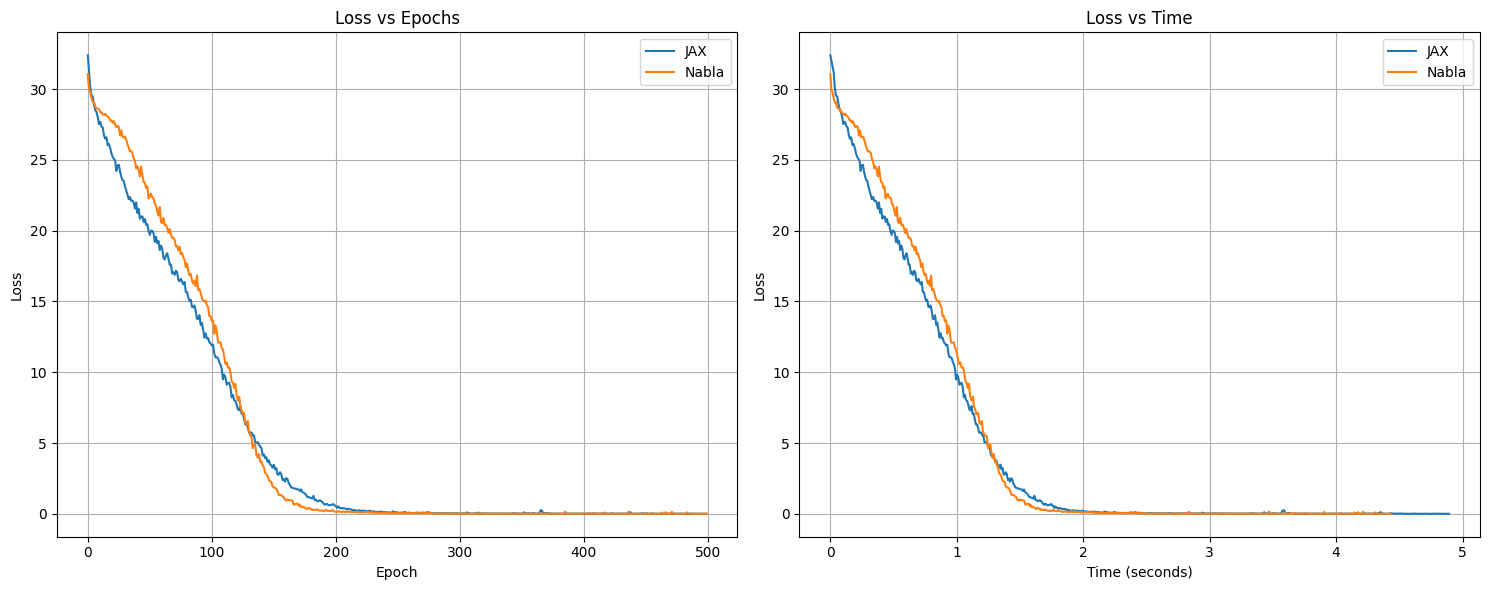

In [22]:
# Plot the loss curves for both implementations
plot_loss_curves(
    jax_loss_history, jax_time_history, nabla_loss_history, nabla_time_history
)

## 18. Final Evaluation

Let's evaluate both models on the same test examples to compare their performance.

In [23]:
def evaluate_model(params, predict_fn, create_dataset_fn, framework_name):
    print("\n" + "=" * 60)
    print(f"🧪 FINAL {framework_name.upper()} EVALUATION")
    print("=" * 60)

    # Test on 5 random examples
    for i in range(5):
        test_enc_in, _, test_target = create_dataset_fn(1)
        prediction = predict_fn(test_enc_in[0], params)

        if framework_name == "jax":
            is_correct = jnp.array_equal(prediction[1:], test_target[0])
            print(f"Example {i + 1}:")
            print(f"  Input:           {test_enc_in[0]}")
            print(f"  Expected output: {test_target[0]}")
            print(f"  Predicted:       {prediction[1:]}")
            print(f"  Correct:         {'✅ YES' if is_correct else '❌ NO'}")
        else:  # nabla
            is_correct = np.array_equal(
                prediction[1:].to_numpy(), test_target[0].to_numpy()
            )
            print(f"Example {i + 1}:")
            print(f"  Input:           {test_enc_in[0]}")
            print(f"  Expected output: {test_target[0]}")
            print(f"  Predicted:       {prediction[1:]}")
            print(f"  Correct:         {'✅ YES' if is_correct else '❌ NO'}")


# Evaluate JAX model
evaluate_model(jax_params, predict_sequence_jax, create_reverse_dataset_jax, "jax")

# Evaluate Nabla model
evaluate_model(
    nabla_params, predict_sequence_nabla, create_reverse_dataset_nabla, "nabla"
)


🧪 FINAL JAX EVALUATION
Example 1:
  Input:           [ 3 16  6  6  3  4 10  4  8]
  Expected output: [ 8  4 10  4  3  6  6 16  3  2]
  Predicted:       [ 8  4 10  4  3  6  6 16  3  2]
  Correct:         ✅ YES
Example 2:
  Input:           [ 6  7 14  6  3 17  6 15  4]
  Expected output: [ 4 15  6 17  3  6 14  7  6  2]
  Predicted:       [ 4 15  6 17  3  6 14  7  6  2]
  Correct:         ✅ YES
Example 3:
  Input:           [15 12 13 15 13  8  7  4  3]
  Expected output: [ 3  4  7  8 13 15 13 12 15  2]
  Predicted:       [ 3  4  7  8 13 15 13 12 15  2]
  Correct:         ✅ YES
Example 4:
  Input:           [ 8  4 17  3 12 10  8  5 14]
  Expected output: [14  5  8 10 12  3 17  4  8  2]
  Predicted:       [14  5  8 10 12  3 17  4  8  2]
  Correct:         ✅ YES
Example 5:
  Input:           [ 4 19 17 18  6 12 11 15 10]
  Expected output: [10 15 11 12  6 18 17 19  4  2]
  Predicted:       [10 15 11 12  6 18 17 19  4  2]
  Correct:         ✅ YES

🧪 FINAL NABLA EVALUATION
Example 1:
  Input: 